# Exploratory Data Analysis - Billboard Hot 100 & Spotify Track Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
songs = pd.read_csv('../data/raw/new', index_col=0)

In [3]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1094 entries, 0 to 1093
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rank              1094 non-null   int64  
 1   Date              1094 non-null   object 
 2   BB_Title          1094 non-null   object 
 3   BB_Artist         1094 non-null   object 
 4   PeakPos           1094 non-null   int64  
 5   LastPos           1094 non-null   int64  
 6   Weeks             1094 non-null   int64  
 7   SP_Title          1073 non-null   object 
 8   SP_Artist         1073 non-null   object 
 9   Match_Ratio       1073 non-null   float64
 10  SP_id             1073 non-null   object 
 11  Genres            1057 non-null   object 
 12  danceability      1073 non-null   float64
 13  energy            1073 non-null   float64
 14  key               1073 non-null   float64
 15  loudness          1073 non-null   float64
 16  mode              1073 non-null   float64


In [4]:
songs.head()

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks,SP_Title,SP_Artist,Match_Ratio,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6,STAY (with Justin Bieber),The Kid LAROI,100.0,...,-5.484,1.0,0.0483,0.0383,0.000000,0.1030,0.478,169.928,141806.0,4.0
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8,Bad Habits,Ed Sheeran,100.0,...,-3.712,0.0,0.0348,0.0469,0.000031,0.3640,0.591,126.026,231041.0,4.0
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14,good 4 u,Olivia Rodrigo,100.0,...,-5.044,1.0,0.1540,0.3350,0.000000,0.0849,0.688,166.928,178147.0,4.0
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1,Rumors (feat. Cardi B),Lizzo,100.0,...,-5.524,0.0,0.0880,0.1300,0.000000,0.4180,0.607,118.992,172833.0,4.0
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19,Kiss Me More (feat. SZA),Doja Cat,100.0,...,-3.541,1.0,0.0286,0.2350,0.000158,0.1230,0.742,110.968,208867.0,4.0


In [5]:
songs = songs[songs.Match_Ratio > 50].dropna(axis=0, subset=['SP_id']).\
                        drop_duplicates(subset='SP_id',keep='first').reset_index(drop = True)

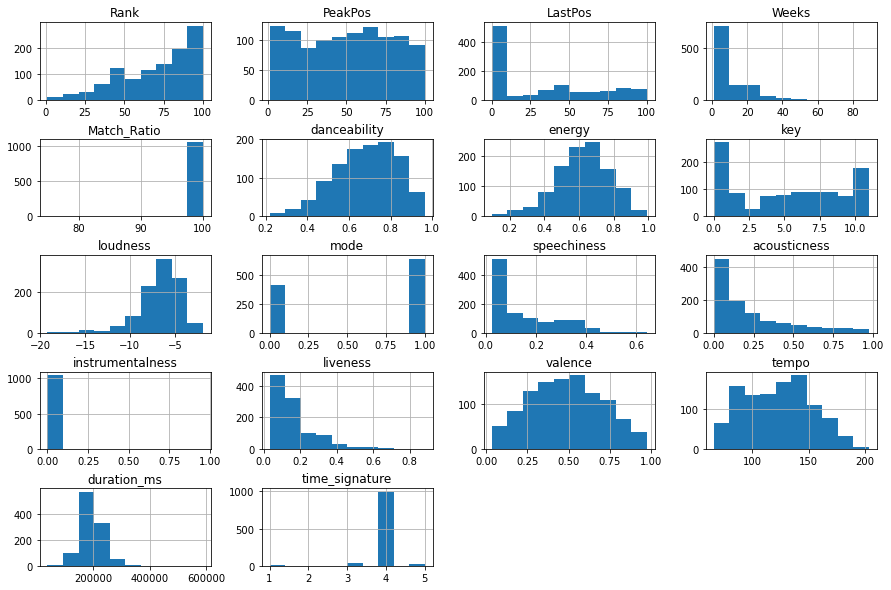

In [6]:
songs.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

In [7]:
songs.instrumentalness.value_counts().sort_values(ascending=False)

0.000000    732
0.000002      3
0.000004      2
0.000018      2
0.000002      2
           ... 
0.000003      1
0.000224      1
0.000006      1
0.000002      1
0.000070      1
Name: instrumentalness, Length: 313, dtype: int64

In [8]:
songs = songs.drop(columns=['Rank','BB_Title', 'BB_Artist','LastPos','Match_Ratio','instrumentalness'])
songs

,Date,PeakPos,Weeks,SP_Title,SP_Artist,SP_id,Genres,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_ms,time_signature
0,2021-08-28,1,6,STAY (with Justin Bieber),The Kid LAROI,5HCyWlXZPP0y6Gqq8TgA20,australian hip hop,0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,0.1030,0.478,169.928,141806.0,4.0
1,2021-08-28,2,8,Bad Habits,Ed Sheeran,6PQ88X9TkUIAUIZJHW2upE,"pop,uk pop",0.808,0.897,11.0,-3.712,0.0,0.0348,0.0469,0.3640,0.591,126.026,231041.0,4.0
2,2021-08-28,1,14,good 4 u,Olivia Rodrigo,4ZtFanR9U6ndgddUvNcjcG,pop,0.563,0.664,9.0,-5.044,1.0,0.1540,0.3350,0.0849,0.688,166.928,178147.0,4.0
3,2021-08-28,4,1,Rumors (feat. Cardi B),Lizzo,6KgtcmCF9Ky68XC7ezxl3s,"dance pop,escape room,minnesota hip hop,pop,po...",0.827,0.731,4.0,-5.524,0.0,0.0880,0.1300,0.4180,0.607,118.992,172833.0,4.0
4,2021-08-28,3,19,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,"dance pop,pop",0.762,0.701,8.0,-3.541,1.0,0.0286,0.2350,0.1230,0.742,110.968,208867.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,2020-03-07,89,1,Bat Man,YoungBoy Never Broke Again,6fEdWrEYspdneQMNIT33I4,"baton rouge rap,trap",0.782,0.670,1.0,-4.332,0.0,0.3580,0.1180,0.0956,0.745,172.006,178655.0,4.0
1059,2020-03-07,93,1,Shake The Room (feat. Quavo),Pop Smoke,7rSnKi58HPIVC0FVyh04Q1,brooklyn drill,0.733,0.684,2.0,-4.748,1.0,0.1770,0.1420,0.1790,0.437,142.040,165640.0,4.0
1060,2020-03-07,30,7,Rare,Selena Gomez,7HMmFQsKsljwTw8bS7lu19,"dance pop,pop,post-teen pop",0.838,0.545,5.0,-6.713,1.0,0.0706,0.2080,0.1030,0.631,114.998,220590.0,4.0
1061,2020-03-07,58,2,Me and My Guitar,A Boogie Wit da Hoodie,6cZH4rX1KTt1aJ3Ql6Ynja,"melodic rap,pop rap,rap,trap",0.644,0.587,7.0,-6.736,0.0,0.3530,0.4730,0.0759,0.680,173.972,161765.0,4.0


In [9]:
songs.PeakPos.value_counts().sort_values(ascending=False)

1     41
65    19
16    18
86    17
71    17
      ..
93     5
96     4
77     3
73     3
7      2
Name: PeakPos, Length: 100, dtype: int64

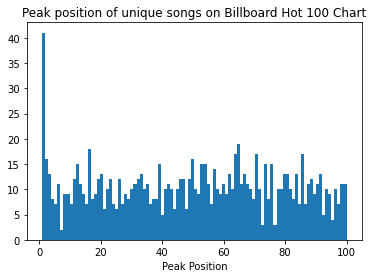

In [10]:
plt.hist(songs.PeakPos,bins=100)
plt.xlabel('Peak Position')
plt.title('Peak position of unique songs on Billboard Hot 100 Chart')
plt.show()

In [11]:
#songs.Weeks.value_counts().sort_values(ascending=False)

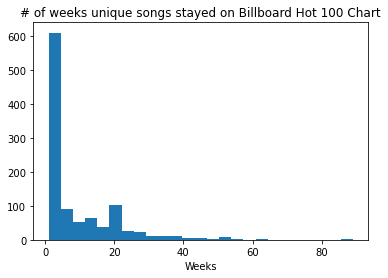

In [12]:
plt.hist(songs.Weeks,bins=25)
plt.xlabel('Weeks')
plt.title('# of weeks unique songs stayed on Billboard Hot 100 Chart')
plt.show()

In [13]:
songs.corr()

,PeakPos,Weeks,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_ms,time_signature
PeakPos,1.000000,-0.624905,0.036978,0.107728,-0.013266,0.034367,-0.035136,0.182831,-0.093985,-0.010537,-0.016982,-0.009418,-0.068949,0.030412
Weeks,-0.624905,1.000000,-0.015261,-0.034231,0.033650,0.043814,0.015070,-0.198738,0.026057,-0.037527,0.078638,-0.070625,-0.000874,-0.038245
danceability,0.036978,-0.015261,1.000000,0.071505,0.056999,0.179908,-0.136544,0.303871,-0.369996,-0.082594,0.261661,0.043851,-0.200976,0.123716
energy,0.107728,-0.034231,0.071505,1.000000,0.059195,0.737237,-0.025569,0.023702,-0.509506,0.128882,0.315963,0.096825,0.000894,0.110350
key,-0.013266,0.033650,0.056999,0.059195,1.000000,0.045657,-0.162637,-0.005762,0.004106,0.039087,0.114156,-0.018526,-0.072840,0.013332
loudness,0.034367,0.043814,0.179908,0.737237,0.045657,1.000000,-0.006223,-0.020272,-0.484931,0.057262,0.189809,0.081628,0.012486,0.089840
mode,-0.035136,0.015070,-0.136544,-0.025569,-0.162637,-0.006223,1.000000,-0.096938,0.052767,-0.046695,-0.004715,-0.004898,0.046555,-0.018717
speechiness,0.182831,-0.198738,0.303871,0.023702,-0.005762,-0.020272,-0.096938,1.000000,-0.207975,0.097303,0.065231,0.165196,-0.147804,0.032684
acousticness,-0.093985,0.026057,-0.369996,-0.509506,0.004106,-0.484931,0.052767,-0.207975,1.000000,-0.036828,-0.065189,-0.096797,0.079217,-0.075692
liveness,-0.010537,-0.037527,-0.082594,0.128882,0.039087,0.057262,-0.046695,0.097303,-0.036828,1.000000,0.059945,0.000546,0.014364,-0.059122


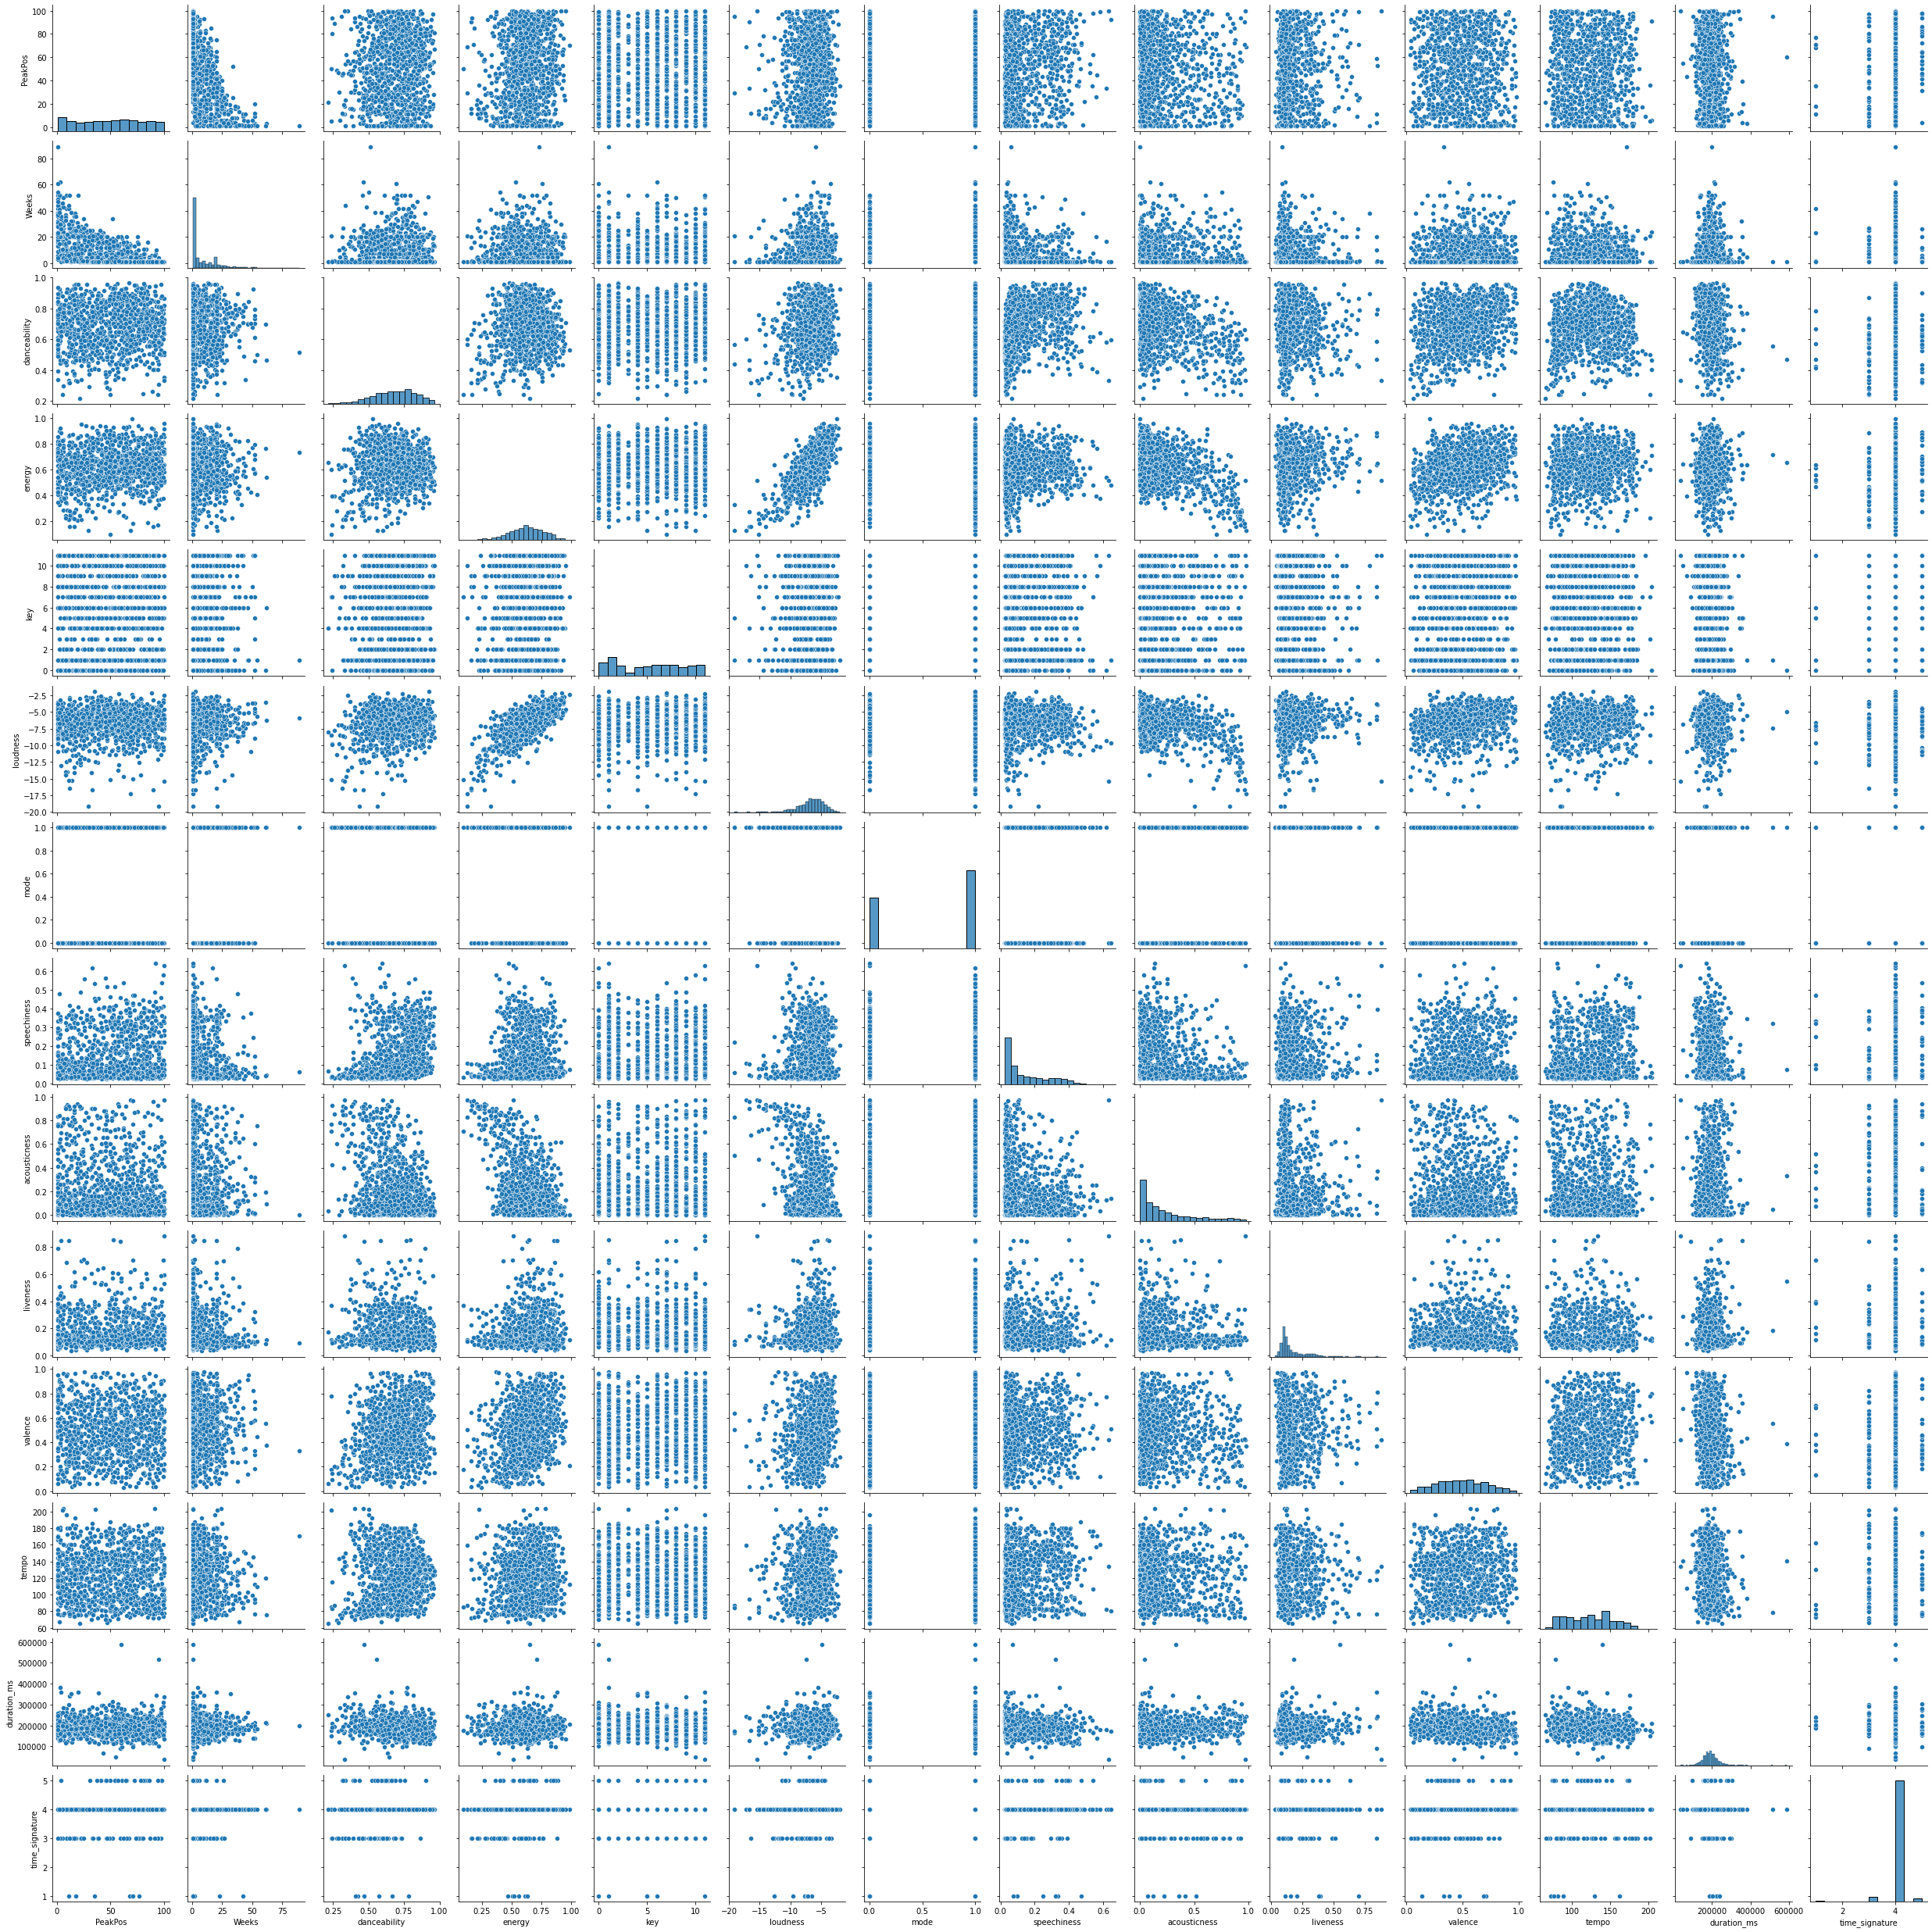

In [14]:
sns.pairplot(songs)
plt.show()

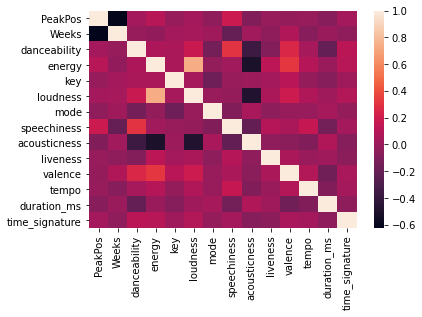

In [15]:
sns.heatmap(songs.corr())
plt.show()

In [17]:
songs_1 = songs[songs.PeakPos == 1]

songs_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PeakPos,41.0,1.000000,0.000000,1.0000,1.0000,1.0000,1.000,1.000
Weeks,41.0,27.975610,17.300994,3.0000,18.0000,23.0000,38.000,89.000
danceability,41.0,0.683415,0.136860,0.3360,0.5910,0.7010,0.777,0.935
energy,41.0,0.615756,0.143937,0.3430,0.4810,0.6270,0.741,0.855
key,41.0,4.902439,4.241491,0.0000,1.0000,6.0000,9.000,11.000
loudness,41.0,-6.547195,1.888090,-10.9650,-7.9560,-6.0440,-5.187,-3.497
mode,41.0,0.634146,0.487652,0.0000,0.0000,1.0000,1.000,1.000
speechiness,41.0,0.115627,0.102188,0.0276,0.0419,0.0588,0.159,0.375
acousticness,41.0,0.202445,0.228123,0.0012,0.0215,0.1220,0.321,0.835
liveness,41.0,0.186390,0.143473,0.0461,0.0936,0.1140,0.260,0.790


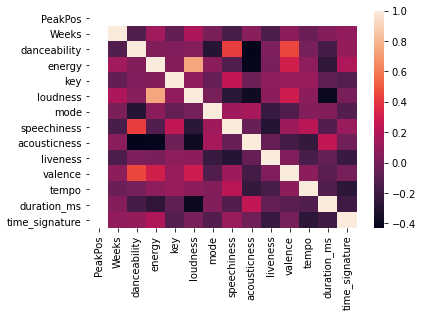

In [16]:
sns.heatmap(songs_1.corr())
plt.show()